#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/AIVLE/AI_미니프로젝트 1차_실습자료'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    #학습곡선 함수 그리기

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_df = pd.read_csv(path + '/data01_train.csv')
test_df = pd.read_csv(path + '/data01_test.csv')
feature_df = pd.read_csv(path + '/features.csv')

In [ ]:
#불필요한 칼럼을 삭제하세요.
train_df = train_df.drop(['subject'], axis=1)
test_df = test_df.drop(['subject'], axis=1)

#'subject'는 불필요한 칼럼이므로 삭제

In [ ]:
train_df.head(), test_df.head(), feature_df.head()
#상위 5개 데이터 조회

(   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
 0           0.288508          -0.009196          -0.103362         -0.988986   
 1           0.265757          -0.016576          -0.098163         -0.989551   
 2           0.278709          -0.014511          -0.108717         -0.997720   
 3           0.289795          -0.035536          -0.150354         -0.231727   
 4           0.394807           0.034098           0.091229          0.088489   
 
    tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
 0         -0.962797         -0.967422         -0.989000         -0.962596   
 1         -0.994636         -0.987435         -0.990189         -0.993870   
 2         -0.981088         -0.994008         -0.997934         -0.982187   
 3         -0.006412         -0.338117         -0.273557          0.014245   
 4         -0.106636         -0.388502         -0.010469         -0.109680   
 
    tBodyAcc-mad()-Z  tBodyAcc-max()-X  ..

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
print(train_df.shape)
print(test_df.shape)

(5881, 562)
(1471, 562)


In [ ]:
#전체 데이터의 상위 5개 행 확인
train_df.head(), test_df.head(), feature_df.head()

(   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
 0           0.288508          -0.009196          -0.103362         -0.988986   
 1           0.265757          -0.016576          -0.098163         -0.989551   
 2           0.278709          -0.014511          -0.108717         -0.997720   
 3           0.289795          -0.035536          -0.150354         -0.231727   
 4           0.394807           0.034098           0.091229          0.088489   
 
    tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
 0         -0.962797         -0.967422         -0.989000         -0.962596   
 1         -0.994636         -0.987435         -0.990189         -0.993870   
 2         -0.981088         -0.994008         -0.997934         -0.982187   
 3         -0.006412         -0.338117         -0.273557          0.014245   
 4         -0.106636         -0.388502         -0.010469         -0.109680   
 
    tBodyAcc-mad()-Z  tBodyAcc-max()-X  ..

In [ ]:
#전체 데이터의 수치형 변수 분포 확인
display(train_df.describe())
display(test_df.describe())
display(feature_df.describe())

# display:전체 데이터 확인

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


,sensor,agg,axis,feature_name
count,561,561,436,561
unique,18,27,62,561
top,fBodyGyro,bandsEnergy(),X,"angle(Z,gravityMean)"
freq,79,126,76,1


In [ ]:
#전체 데이터의 모든 변수 확인
display(train_df.columns)
display(test_df.columns)
display(feature_df.columns)

# display:전체 데이터 확인

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

Index(['sensor', 'agg', 'axis', 'feature_name'], dtype='object')

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# 데이터 분할을 합니다.
X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

X_train.head(), y_train.head()

#데이터 분할

(   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
 0           0.288508          -0.009196          -0.103362         -0.988986   
 1           0.265757          -0.016576          -0.098163         -0.989551   
 2           0.278709          -0.014511          -0.108717         -0.997720   
 3           0.289795          -0.035536          -0.150354         -0.231727   
 4           0.394807           0.034098           0.091229          0.088489   
 
    tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
 0         -0.962797         -0.967422         -0.989000         -0.962596   
 1         -0.994636         -0.987435         -0.990189         -0.993870   
 2         -0.981088         -0.994008         -0.997934         -0.982187   
 3         -0.006412         -0.338117         -0.273557          0.014245   
 4         -0.106636         -0.388502         -0.010469         -0.109680   
 
    tBodyAcc-mad()-Z  tBodyAcc-max()-X  ..

In [ ]:
# 데이터 분할을 합니다. (test)
X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

X_test.head(), y_test.head()

#데이터 분할

(   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
 0           0.284379          -0.021981          -0.116683         -0.992490   
 1           0.277440          -0.028086          -0.118412         -0.996620   
 2           0.305833          -0.041023          -0.087303          0.006880   
 3           0.276053          -0.016487          -0.108381         -0.995379   
 4           0.271998           0.016904          -0.078856         -0.973468   
 
    tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
 0         -0.979640         -0.963321         -0.992563         -0.977304   
 1         -0.927676         -0.972294         -0.997346         -0.931405   
 2          0.182800         -0.237984          0.005642          0.028616   
 3         -0.983978         -0.975854         -0.995877         -0.985280   
 4         -0.702462         -0.869450         -0.979810         -0.711601   
 
    tBodyAcc-mad()-Z  tBodyAcc-max()-X  ..

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()                         # MinMaxScaler 실행

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 정수 인코딩 변환(LabelEncoder)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
# 기존 레이블 저장
labels = le.classes_
labels

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.8,
                                                  random_state=7)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

#train:val 을 통한 데이터 분할

((4704, 561), (1177, 561), (4704,), (1177,))

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

In [ ]:
input_dim = X_train.shape[1]
num_classes = len(le.classes_)

NameError: name 'X_train' is not defined

In [ ]:
models = []

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [ ]:
# 모델 설계(keras)
input_dim = X_train.shape[1]
num_classes = len(le.classes_)

models.append(Sequential([
    Dense(num_classes, activation='softmax', input_shape=(X_train.shape[1],))
]))

#softmax:다중분류 모델, Hidden Layer 필요없음

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 컴파일 및 학습
models[0].compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#다중분류모델을 위해 crossentropy 사용

In [ ]:
models[0].summary()   #모델 요약

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epoch = 5     #학습 횟수

In [ ]:
hist = models[0].fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epoch,
                        verbose=1)
# validation_data : train 데이터의 일부를 활용, 정확도를 더 올림

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4755 - loss: 1.2831 - val_accuracy: 0.8403 - val_loss: 0.7693
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8463 - loss: 0.7004 - val_accuracy: 0.8760 - val_loss: 0.5619
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8789 - loss: 0.5271 - val_accuracy: 0.8912 - val_loss: 0.4609
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9001 - loss: 0.4368 - val_accuracy: 0.8989 - val_loss: 0.3986
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9043 - loss: 0.3830 - val_accuracy: 0.9167 - val_loss: 0.3529


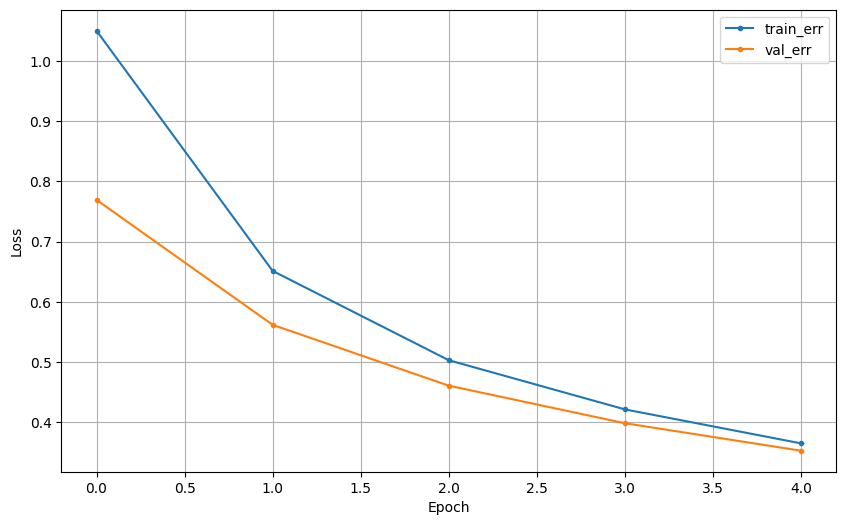

In [ ]:
dl_history_plot(hist.history)
#히스토그램, 시각화 표현

In [ ]:
test_loss, test_acc = models[0].evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

#테스트 정확도 파악

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9020 - loss: 0.3489
Test accuracy: 0.9041468501091003


In [ ]:
hist.history.keys()

#딕셔너리 형태로 저장

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
sum(hist.history['accuracy']) / 5

#반복수행해서 얻은 성능의 평균값

0.8356292605400085

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [ ]:
# 모델 설계(keras)
input_dim = X_train.shape[1]
num_classes = len(le.classes_)

models.append(Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu', input_shape=(64,)),
    Dense(16, activation='relu', input_shape=(32,)),
    Dense(8, activation='relu', input_shape=(16,)),
    Dense(4, activation='relu', input_shape=(8,)),    #Dense layer 코드 사용 keras 코드
    Dense(num_classes, activation='softmax')
]))



In [ ]:
# 컴파일 및 학습
models[1].compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
models[1].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,778 (151.48 KB)

 Trainable params: 38,778 (151.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = models[1].fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epoch,
                        verbose=1)

# validation_data : train 데이터의 일부를 활용, 정확도를 더 올림

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3903 - loss: 1.4673 - val_accuracy: 0.4435 - val_loss: 1.0512
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5486 - loss: 0.8852 - val_accuracy: 0.5905 - val_loss: 0.7376
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6244 - loss: 0.6851 - val_accuracy: 0.6117 - val_loss: 0.6762
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6894 - loss: 0.6122 - val_accuracy: 0.9065 - val_loss: 0.2698
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9099 - loss: 0.2351 - val_accuracy: 0.9261 - val_loss: 0.1805


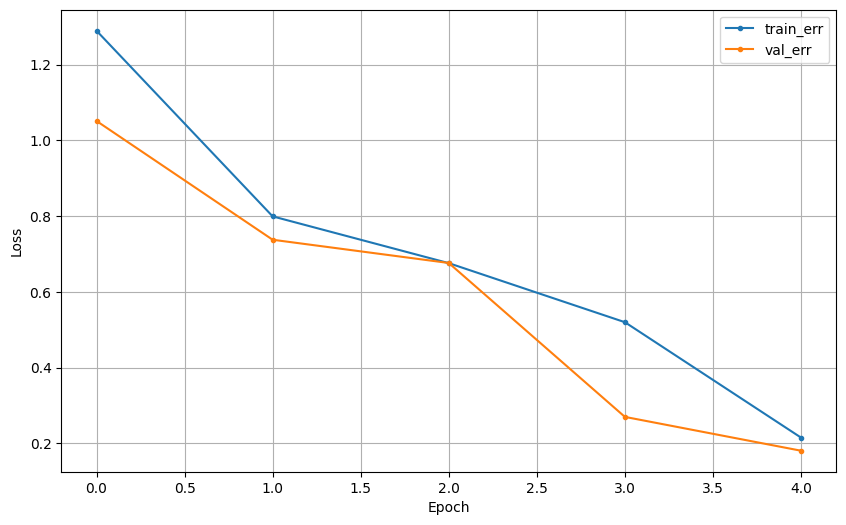

In [ ]:
# 학습곡선
dl_history_plot(hist.history)

#학습 곡선 추가

In [ ]:
# 예측 및 평가
test_loss, test_acc = models[1].evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

#모델 예측 및 평가 정확도가 매우 높음

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9266 - loss: 0.1742
Test accuracy: 0.9252209663391113


In [ ]:
sum(hist.history['accuracy']) / 5

#정확도 총합

0.6614370763301849

### (3) 모델3 : 학습률, epoch 등 조정

In [ ]:
# 모델 설계(keras)
models.append(Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu', input_shape=(64,)),
    Dense(16, activation='relu', input_shape=(32,)),   # 학습률 조정
    Dense(num_classes, activation='softmax')
]))

#keras 코드  활용, softmax 다중분류모델

In [ ]:
# 컴파일 및 학습
models[2].compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#crossentropy 사용

In [ ]:
models[2].summary()

hist = models[2].fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=10,
                        verbose=1)

# validation_data 정확도를 높임 아래를 살펴보면 정확도가 매우 높다는 것을 알 수 있다

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 38,678 (151.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5741 - loss: 1.2007 - val_accuracy: 0.8037 - val_loss: 0.4602
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.3627 - val_accuracy: 0.9082 - val_loss: 0.2730
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9144 - loss: 0.2332 - val_accuracy: 0.9235 - val_loss: 0.2109
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9282 - loss: 0.1921 - val_accuracy: 0.8946 - val_loss: 0.2210
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9456 - loss: 0.1536 - val_accuracy: 0.9337 - val_loss: 0.1591
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9481 - loss: 0.1327 - val_accuracy: 0.9507 - val_loss: 0.1233
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9612 - loss: 0.1023 - val_accuracy: 0.9660 - val_loss: 0.0932
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9684 - loss: 0.0860 - val_accuracy: 0.

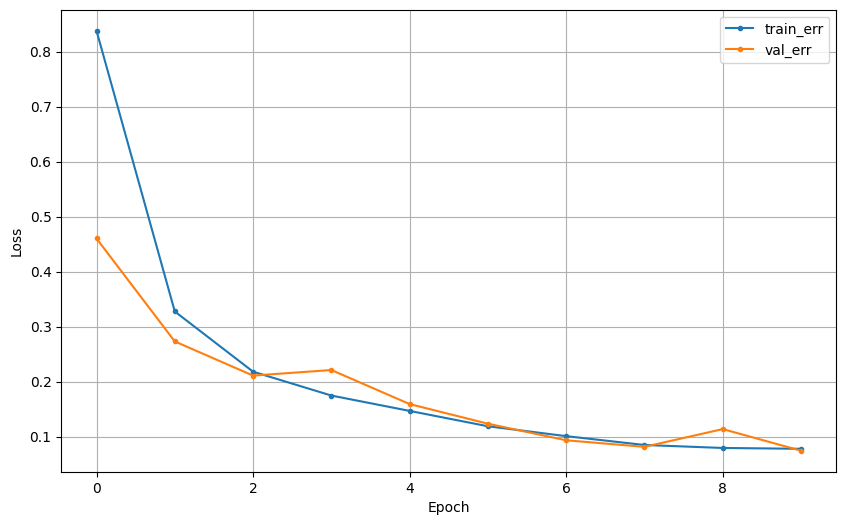

In [ ]:
# 학습곡선
dl_history_plot(hist.history)

In [ ]:
# 예측 및 평가
test_loss, test_acc = models[2].evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 0.0933
Test accuracy: 0.96872878074646


In [ ]:
sum(hist.history['accuracy']) / 10

0.9215348660945892

### (4) 모델4 :  학습률, epoch 등 조정

In [ ]:
# 모델 설계(keras)
models.append(Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu', input_shape=(64,)),
    Dense(16, activation='relu', input_shape=(32,)),
    Dense(num_classes, activation='softmax')
]))

In [ ]:
# 컴파일 및 학습
models[3].compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
models[3].summary()

hist = models[3].fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=10,
                        verbose=1)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,678 (151.09 KB)

 Trainable params: 38,678 (151.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3717 - loss: 1.4481 - val_accuracy: 0.7298 - val_loss: 0.6974
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6574 - loss: 0.7539 - val_accuracy: 0.8428 - val_loss: 0.4740
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7571 - loss: 0.5568 - val_accuracy: 0.8539 - val_loss: 0.3526
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8211 - loss: 0.4272 - val_accuracy: 0.8879 - val_loss: 0.2885
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.3689 - val_accuracy: 0.9014 - val_loss: 0.2727
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8713 - loss: 0.3254 - val_accuracy: 0.9303 - val_loss: 0.1962
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8870 - loss: 0.2970 - val_accuracy: 0.9193 - val_loss: 0.2039
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8859 - loss: 0.2808 - val_accuracy: 0.

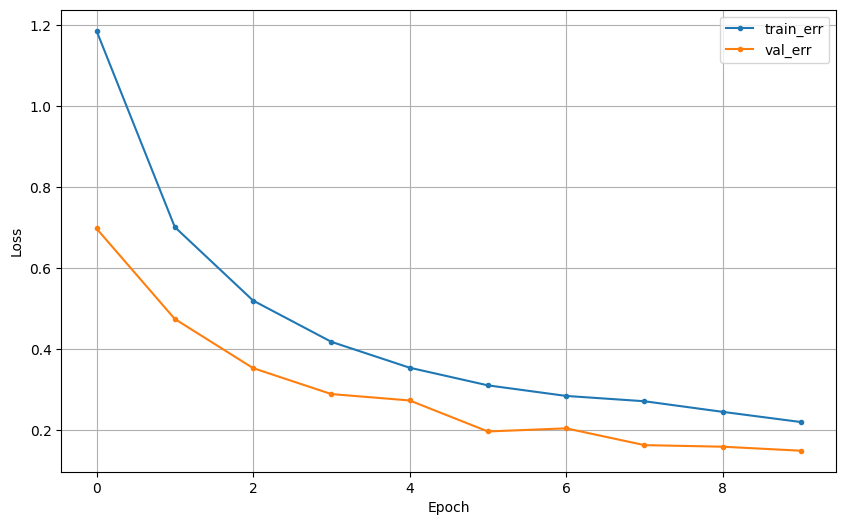

In [ ]:
# 학습곡선
dl_history_plot(hist.history)

In [ ]:
# 예측 및 평가
test_loss, test_acc = models[3].evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# 테스트 정확도 평가

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9442 - loss: 0.1521
Test accuracy: 0.9428960084915161


In [ ]:
sum(hist.history['accuracy']) / 10

0.8105017066001892

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기(test)
test_df = pd.read_csv(path + '/data01_test.csv')

# subject 삭제
test_df.drop(['subject'], axis=1, inplace=True)

# x, y 분할
X_test = test_df.drop('Activity', axis=1)
y_test = test_df['Activity']

# x : 스케일링 적용
X_test = scaler.transform(X_test)

# y : 정수인코딩 적용
y_test = le.transform(y_test)         # 성능 비교를 위한 작업을 수행합니다.

In [ ]:
# test 데이터에 대한 성능 측정
for model in models:
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print('Test accuracy:', test_acc)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9020 - loss: 0.3489
Test accuracy: 0.9041468501091003
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9266 - loss: 0.1742
Test accuracy: 0.9252209663391113
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 0.0933
Test accuracy: 0.96872878074646
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9442 - loss: 0.1521
Test accuracy: 0.9428960084915161


#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.